# 权重衰减

以参数w的L2范数为惩罚项 

### 2. 高维线性回归

In [97]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [98]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w = torch.ones(num_inputs) * 0.01
true_b = 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)

test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 3. 从零开始实现

#### 3.1. 初始化模型参数

In [99]:
def init_params():
    w = torch.normal(0, 1, (num_inputs,1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return w, b

#### 3.2. 定义L2范数惩罚

In [100]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

#### 3.3. 定义训练代码实现

In [101]:
def train(lambd):
    w, b = init_params()
    net = lambda X: torch.matmul(X, w) + b
    loss = d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd((w, b), lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是:', torch.norm(w).item())


#### 3.4. 忽略正则化直接训练


In [102]:
# train(lambd=0)

#### 3.5. 使用权重衰减

In [103]:
# train(lambd=3)

### 4. 简洁实现

由于权重衰减在神经网络优化中很常用， 深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中，以便与任何损失函数结合使用。 此外，这种集成还有计算上的好处， 允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。 由于更新的权重衰减部分仅依赖于每个参数的当前值， 因此优化器必须至少接触每个参数一次。

In [104]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    optim = torch.optim.SGD([
        {'params':net[0].weight, 'weight_decay':wd},
        {'params':net[0].bias}], lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optim.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optim.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数:', net[0].weight.norm().item())



w的L2范数: 14.670133590698242


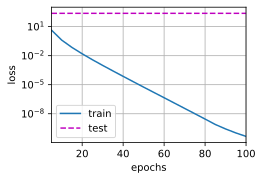

In [105]:
train_concise(0)

w的L2范数: 0.40437984466552734


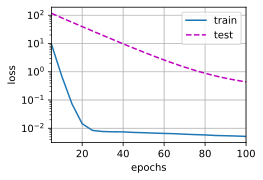

In [106]:
train_concise(3)

 在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

### 5. 小结

- 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。

- 保持模型简单的一个特别的选择是使用L2惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。

- 权重衰减功能在深度学习框架的优化器中提供。

- 在同一训练代码实现中，不同的参数集可以有不同的更新行为。